# Prosjekt 2: Introduksjon til maskinlæring
## Frederick Nilsen, Mia Rødde, Sara Abnar

### Initialisering og generell algoritme

In [1]:
## IMPORTS

import numpy as np #Numpy-biblioteket
import matplotlib.pyplot as plt #Generell plotting
from loader import * #Utdelt kode for innlastning av MNIST-data
from plotting import * #Plottingfunksjoner fra utdelt kode
from spirals import get_data_spiral_2d #Spiralgenererende funksjon fra utdelt kode
import pickle # Lar oss lagre en binær dump av vekter fra trening

In [2]:
## GLOBAL CONSTS AND DEFINITIONS

sigma = lambda x : np.tanh(x)         # Activation function
eta = lambda x : 0.5*(1+np.tanh(x/2)) # Scalar function     
eta_ddx = lambda x :  0.25*(1-np.tanh(x/2)*np.tanh(x/2)) # Derivative of eta
sigma_ddx = lambda x: 1-(np.tanh(x))**2 # Derivative of sigma

##### Global consts for the first dataset
K = 10 # Antall lag
d = 2 # Antall dimensjoner
tau = 0.1 # Læringsparameter, brukes i "plain vanilla"-algoritmen, [0.01,0.1]
np.random.seed(0) #Definerer vårt seed, gjør det enklere å debugge
Y0, C = get_data_spiral_2d(200) #Default n=200
I = Y0.shape[1]

np.random.seed(0)
W = np.random.randn(K,d,d)
np.random.seed(0)
b = np.random.randn(K,d,1)     #W,b,mu og w initieres med tilfeldige verdier 
np.random.seed(0)
mu = np.random.randn()
np.random.seed(0)
w = np.random.randn(d,1)
h = 0.25 # Steglengde

Ulst = [W, b, w, mu] # Python-liste bestående av vektobjektene, brukes bl.a Adam-metoden

In [3]:
## Funksjoner

'''
saveU dumper binærdata av vektene (Ulst), til tekstfil.
Dette muliggjør å opphente vektene for testing av presisjon uten å måtte trene algoritmen på nytt
loadU laster inn Ulst fra en innlastet fil. Antatt at fil eksisterer og ikke kaster exception
'''
def saveU(dataset="spirals"):
    with open('weights-' + dataset + '.txt', 'wb') as f:
        pickle.dump(Ulst,f)

def loadU(dataset="spirals"):
    with open('weights' + dataset + '.txt','r') as f:
        pickle.load(f)
'''
Labels, C, er en array av bools. Her har vi antatt at true er rød og false er blå,
og tilordnet fargene som brukes til plotting. Bruker list comprehension
'''
def getColorFromLabel(C):
    colorLst = []
    colorLst.append('r' if value else 'b' for value in C)
    return colorLst
C_colors = getColorFromLabel(C) #Fargeliste til plotting for første datasett


'''
YK(W,b,Ystart=Y0)
Tar inn vektene W og b eventuelt en egendefinert startverdi for Y. Som standard brukes Y0 fra spiraloppgaven,
men dersom spesifisert fungerer den tilsvarende for MNIST-oppgaven.
Funksjonen tilsvarer likning (1) i oppgavetekst.
'''
def YK(W, b, Ystart=Y0):
    #tom Y-matrise, 3-dimensjonalt numpy-array
    Ym = np.zeros((K+1,d,I))
    Ym[0,:,:] = np.copy(Ystart)
    k=0
    while k < K:
        Ym[k+1] = Ym[k] + h*sigma(W[k]@Ym[k] + b[k])
        k+=1
    return Ym

'''
getGradients
Tar inn lag K, samt vektene, C og Y og regner ut alle gradienter som beskrevet i prosjektbeskrivelsen og returnerer dem.
Store deler av koden er en implementasjon av henholdsvis likning (5), (6), (7), (8) og (9)
Også getGradients tar utgangspunkt i data fra spiraloppgave med mindre annet er spesifisert.
Alle arrays deklareres med np.zeros(), og fylles deretter opp som beskrevet i oppgaveteksten.
'''
def getGradients(K, W, b, w, mu, c=C, Ystart=Y0):
    Y_all = YK(W,b, Ystart) #Kan vi droppe denne plis? Og heller bruke YK_list som er global?
    lastY = Y_all[-1,:,:]
    P = np.zeros((Y_all.shape)) #Initalisering
    P[K,:,:] = w@np.transpose((Zf(w,mu, lastY)-c)*eta_ddx(np.transpose(lastY)@w+mu))  #(7)
    
    dJdMU = eta_ddx(np.transpose(np.transpose(lastY)@w+mu))@(Zf(w,mu, lastY)-c) #(5)
    dJdw = lastY@((Zf(w,mu, lastY)-c)*eta_ddx(np.transpose(lastY)@w+mu))  #(6)
    for k in range(K,0,-1):
        P[k-1,:,:] = P[k,:,:]+h*np.transpose(W[k-1,:,:])@(sigma_ddx(W[k-1,:,:]@Y_all[k-1,:,:]+b[k-1,:,:])*P[k,:,:])  #(8) 
    dJdWk = np.zeros((K,d,d)) #Init
    dJdBk = np.zeros((K,d,1)) #Init
    
    for k in range(0,K):
        dJdWk[k] = h*(P[k+1]*sigma_ddx(W[k,:,:]@Y_all[k,:,:]+b[k,:,:]))@np.transpose(Y_all[k,:,:])  #(9)
        dJdBk[k] = h*(P[k+1]*sigma_ddx(W[k,:,:]@Y_all[k,:,:]+b[k,:,:]))@np.ones((I,1)) #(10)
    return dJdWk, dJdBk, dJdw, dJdMU


'''
AdamAlg
Tar inn liste av vekter (Ulst), Y0 og C fra importert data samt m og v.
Variablene m og v bestemmes av AdamAlg, og er en liste med samme lengde som Ulst.
Counter er en global variabel som følger med på antall iterasjoner og brukes i potensuttrykket til mhat og vhat.

gradLst består av en liste av gradientobjektene fra getGradients(), og vi kjører deretter en for-løkke
for å oppdatere vektene for alle gradienter.
Funksjonen returnerer Ulst, en liste over oppdaterte vekter.
Funksjonen returnerer også m og v da neste kall på funksjonen avhenger av m- og v-verdiene fra forrige beregning.
'''
def AdamAlg(Ulst, m, v, c=C, Ystart=Y0):
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 1e-8
    W, b, w, mu = Ulst
    gradLst = [x for x in getGradients(K, W, b, w, mu, c, Ystart)] #Syntaks tvinger data til liste og ikke tuple
    for i in range(len(gradLst)):
        g = gradLst[i]
        m[i] = beta1*m[i]+(1-beta1)*g
        v[i] = beta2*v[i]+(1-beta2)*(g*g)
        mhat = m[i]/(1-beta1**(counter))
        vhat = v[i]/(1-beta2**(counter))
        Ulst[i] -= alpha*mhat/(np.sqrt(vhat)+epsilon)
    return Ulst, m, v

### Testproblem 1 - punkter i planet

In [4]:
YK_list = YK(W,b) #Denne må være identisk med Y_all i getGradients >:(
lastY = YK_list[-1,:,:]

Zf = lambda w,mu,finalY=lastY : eta(np.transpose(finalY)@w +mu) #(2)
Z=Zf(w,mu) #Flytt til mer oversiktlig plass
Jf = lambda Z=Zf(w,mu), ce=C : 1/2*np.linalg.norm(Z-ce)**2 #(3) Kostnadsfunksjon
J = Jf() #Flytt til mer oversiktlig plass

In [5]:
#Hovedalgoritmecelle
converged = False #Slett
counter = 1 

#initializing list
m = [0 for x in range(len(Ulst))]
v = [0 for x in range(len(Ulst))]

#for AdamAlg
for i in range(1,10001): #"while not converged" gjort om til for med angitt antall iterasjoner
    Ulst, m, v = AdamAlg(Ulst, m, v)
    counter +=1 

W, b, w, mu = Ulst
saveU()

0.17745877840627147


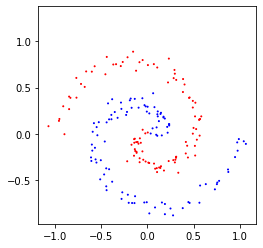

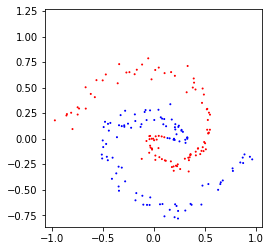

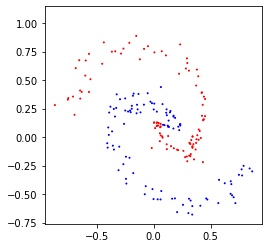

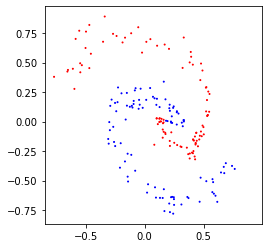

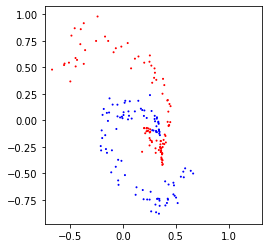

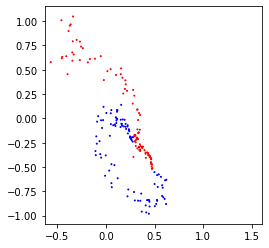

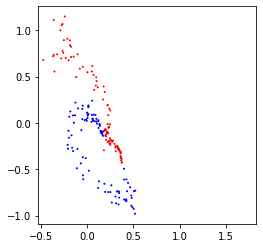

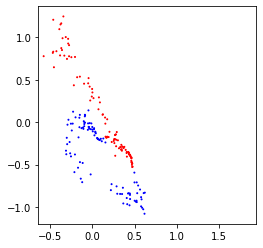

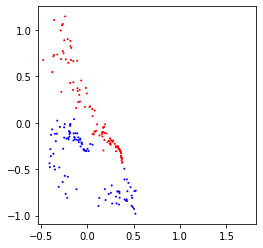

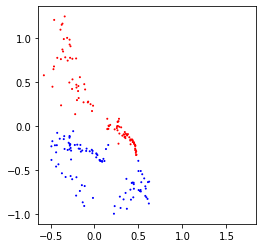

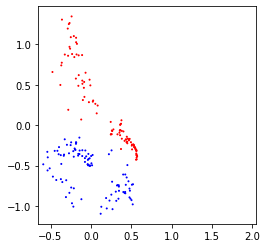

In [6]:
'''
Test-celle for spiraldata
Denne cellen genererer et nytt sett med data for testing, og bruker vektene fra treningen til å beregne Z/Y
Deretter plottes punktene for hvert lag.
'''
testY, testC = get_data_spiral_2d(200) #Er det en idé å lage testing som funksjoner og ikke bare kode i en celle?
#Ulst = loadU()
#W,b,w,mu = Ulst #Fjern kommentar bak hvis du er enig i å gjøre det sånn
trainedY = YK(W, b, testY)
lastY = trainedY[-1,:,:]
print(Jf(Zf(w,mu, lastY), testC)) #Skal vi printe dette?

#forward function
def classifications(K, W, b, w, mu): #Funket dette? Hvis ikke må vi base slette
    def classifying_unknown_points(Y0):
        Y = YK_list[-1,:,:]
        Z = Zf(w, mu, Y)
        return Z
    return classifying_unknown_points
f = classifications(K, W, b, w, mu)
 
#Last function
def classifications2(w, mu): #Funket dette? Hvis ikke må vi base slette
    def classifying_unknown_points2(Y0):
        Z = Zf(w, mu, lastY)
        return Z
    return classifying_unknown_points2
g = classifications2(w, mu)

plot_progression(trainedY, testC)
#plot_model(f, lastY, testC, I) #Funket dette? Hvis ikke må vi base slette
#plot_separation(g, lastY, testC, I) #Funket dette? Hvis ikke må vi base slette

In [7]:
lowerBoundary_setTrueZ = [0.65, 0.75, 0.85, 0.95, 0.99]
'''
checkResults
Tilleggsfunksjon for å systematisere resultatene fra første datsett (spirals)
Beregner Z og J med opptrente vekter og presenterer resultater.
Ser deretter, basert på ulike presisjonsterskeler (lowerBoundary_setTrueZ) om algoritmen har tilordnet rikitg label opp mot C
Linje 19 og 23 bruker list comprehension, men er tilsvarende en "countif"-funksjon,
Teller altså antall True og tall rundt 1, som i spirals vil tilsvare blå farge, og i MNIST er tallet 7/andre digit
^^^^^^ KANSKJE IKKE RIKTIG LINJENUMMER HVIS VI SLETTER TING
'''
def checkResults(n=I):
    testY, testC = get_data_spiral_2d(n)
    trainedY = YK(W, b, testY)
    lastY = trainedY[K,:,:]
    trainedZ = Zf(w,mu,lastY)

    J_new=Jf(trainedZ,testC)
    numTrue=0 #Slett
    numJTrue = 0 #Slett
    print("J_new:", J_new)
    numTrue = sum(1 if testC[i][0] else 0 for i in range(n))
    print("Antall true:", numTrue)
    print("Lower boundary \t Antall true i følge J \t\t Success rate[%]")
    for lowerBound in lowerBoundary_setTrueZ:
        numTrue_J = sum(1 if trainedZ[i][0] >=lowerBound else 0 for i in range(n))
        success_rate = round(numTrue_J/numTrue*100, 5)
        print(lowerBound, numTrue_J, success_rate, sep="\t\t\t")
    

lastY = trainedY[K,:,:]
trainedZ = Zf(w,mu,lastY) #Hva bruker vi disse to til?

In [8]:
checkResults() #Ser rart ut å ha på egen celle?

J_new: 2.9685578797102754
Antall true: 100
Lower boundary 	 Antall true i følge J 		 Success rate[%]
0.65			96			96.0
0.75			96			96.0
0.85			96			96.0
0.95			95			95.0
0.99			85			85.0


### Testproblem 2 - Siffergjenkjenning

In [9]:
#INITIALISING LIST, PART 2
K = 10
Y0pic, C_pic = get_dataset("testing")
d = Y0pic.shape[0]
I = Y0pic.shape[1]

np.random.seed(0)
W = np.random.randn(K,d,d)
np.random.seed(0)
b = np.random.randn(K,d,1)     #Reinitialiserer vektene til tilfeldige verdier
np.random.seed(0) #Brannfakkel: kanskje ha en resetWeights()-funksjon?
mu = np.random.randn()
np.random.seed(0)
w = np.random.randn(d,1)
h = 0.1

Ulst = [W, b, w, mu]

In [ ]:
'''Treningscelle for testsett 2'''
counter = 1

#initializing list
m = [0 for x in range(len(Ulst))]
v = [0 for x in range(len(Ulst))]

#AdamAlg
for i in range(1,101): #"while not converged" gjort om til for med angitt antall iterasjoner
    Ulst, m, v = AdamAlg(Ulst, m, v, C_pic, Y0pic)
    print(counter)
    counter +=1 #Brukes i AdamAlg

saveU("MNIST")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [ ]:
'''Test-celle for MNIST'''
#Ulst = loadU("MNIST")
#W,b,w,mu = Ulst #Fjern kommentar bak hvis du er enig i å gjøre det sånn
W, b, w, mu = Ulst #linje 2-3 vil evt erstatte dette da
testpic, testCp = get_dataset("testing")
I = testpic.shape[1]
d = testpic.shape[0]
trainedPic = YK(W, b, testpic)
lastYPic = trainedPic[K,:,:]

trainedZ = Zf(w, mu, lastYPic)

#koden går mye raskere men J er jo alt for høy: 117.54204154098629 #SLETT FØR VI LEVERER

In [ ]:
lowerBoundary_setTrueZ = [0.65, 0.75, 0.85, 0.95, 0.99, 1.00] #Ulik forrige liste, bør vi holde oss til bare en?
'''
checkResultsPic fungerer på samme måte som checkResults
'''
def checkResultsPic(n=I): #Kanskje prøve å bruke gammel checkResults i stedet for ny funksjon?
    J_new=Jf(trainedZ,testCp)
    numTrue_J = np.array([]) 
    print("J_new:", J_new)
    numTrue = sum(1 if testCp[i][0] else 0 for i in range(n))
    print("Antall true:", numTrue)
    print("Lower boundary \t Antall true i følge J \t\t Success rate[%]")
    for lowerBound in lowerBoundary_setTrueZ:
        numTrue_J = sum(1 if trainedZ[i][0] >=lowerBound else 0 for i in range(n))
        success_rate = round(numTrue_J/numTrue*100, 5)
        print(lowerBound, numTrue_J, success_rate, sep="\t\t\t")

checkResultsPic()